# Multilayer Perceptron

In this notebook, I implement the k-Means Clustering based on the * **Shill Bidding Dataset** *.

I implement the algorithm with the notes defined in * **Data Science & Machine Learning Lecture 3. Introducing the Single Neuron Model** *.
## Algorithm Inplement
---

In [1]:
# Import the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

First, we define our sigmoid activation function, its derivative, and the mean squared error for a single instance of training data.

In [2]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

def mse(a, y):
    return .5*sum((a[i] - y[i])**2 for i in range(len(y)))[0]

Next we write a custom function to initialize the weight matrices and bias column vectors for a dense neural network.

In [3]:
def initialize_weights(layers):
    # The following Python lists will contain numpy matrices
    # connected the layers in the neural network 
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        # The scalling factor is something I found in a research paper :)
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])
    
        W.append(w_temp)
        B.append(b_temp)
    return W, B

Then we define the feedforward phase funciton and the overall MSE cost funciton.

In [22]:
def forward_pass(W, B, xi, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)
        
        a = sigmoid(z)
        A.append(a)
        
    if predict_vector == False:
        return Z, A
    else:
        return A[-1]

def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        xi = xi.reshape(-1,1)
        a = forward_pass(W, B, xi, predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

We are now ready to define a custom Python ```DenseNetwork``` class.

In [5]:
class DenseNetwork(object):
    def __init__(self, layers):
        self.layers = layers
        self.W, self.B = initialize_weights(layers = self.layers)

    def train(self, X_train, y_train, alpha = 0.046, epochs = 10):
        # Print the initial mean squared error
        self.errors_ = [MSE(self.W, self.B, X_train, y_train)]
        print(f"Starting Cost = {self.errors_[0]}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent. 
        for k in range(epochs):
            # Loop over each (xi, yi) training pair of data.
            for xi, yi in zip(X_train, y_train):
                # Use the forward pass function defined before
                # and find the preactivation and postactivation values.
                xi = xi.reshape(-1,1)
                Z, A = forward_pass(self.W, self.B, xi)

                # Store the errors in a dictionary for clear interpretation
                # of computation of these values.
                deltas = dict()

                # Compute the output error 
                output_error = (A[L] - yi)*d_sigmoid(Z[L])
                deltas[L] = output_error

                # Loop from L-1 to 1. Recall the right entry of the range function 
                # is non-inclusive. 
                for i in range(L-1, 0, -1):
                    # Compute the node errors at each hidden layer
                    deltas[i] = (self.W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])

                # Loop over each hidden layer and the output layer to perform gradient 
                # descent. 
                for i in range(1, L+1):
                    self.W[i] -= alpha*deltas[i] @ A[i-1].T
                    self.B[i] -= alpha*deltas[i]

            # Show the user the cost over all training examples
            self.errors_.append(MSE(self.W, self.B, X_train, y_train))   
            print(f"{k + 1}-Epoch Cost = {self.errors_[-1]}")
    

    def predict(self, xi):
        depth = len(self.layers)
        _, A = forward_pass(self.W, self.B, xi)
        return np.argmax(A[-1])

We import the data set and preprocess it.

In [7]:
df = pd.read_csv("../3. Data/Shill_Bidding_Dataset.csv")
df.head()

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7,0


In [24]:
X = df.drop(['Record_ID','Auction_ID','Bidder_ID','Class'],axis=1).values
y = df.Class

# Create training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Then we onehot encode the response variable.

In [25]:
# One hot encode the training labels
onehot_y_train = []

for y in zip(y_train):
    temp_vec = np.zeros((2, 1))
    temp_vec[y][0] = 1.0
    onehot_y_train.append(temp_vec)

We initialize a ```DenseNetwork``` Class with layers = [9,4,4,2]. Then we examine our MLP class by making a random prediction before training.

In [26]:
# Initialize a network with 15 input nodes, two hidden layers with 4 nodes each 
# and a output layer with 2 nodes. 
np.random.seed(1)
net = DenseNetwork(layers = [9,4,4,2])


In [30]:
# Check the mean squared error before training 
print(f"MSE(net.W, net.B, X_train, onehot_y_train) = {MSE(net.W, net.B, X_train, onehot_y_train)} \n")


# Make a random prediction before training
np.random.seed(2)
i = np.random.randint(0, len(X_test))
prediction = net.predict(X_test[i])
print(f"predicted label is: {prediction}")
print(f"actual label is: {np.argmax(y_test[i])}")

MSE(net.W, net.B, X_train, onehot_y_train) = 0.20209970571562078 

predicted label is: 0
actual label is: 0


We train the MLP on the training set with epochs = 10.

In [31]:
# Train your network with stochastic gradient descent!
net.train(X_train, onehot_y_train, alpha = 0.046, epochs= 10)

Starting Cost = 0.20209970571562078
1-Epoch Cost = 0.09704978652825484
2-Epoch Cost = 0.09659095287269039
3-Epoch Cost = 0.09577460828714043
4-Epoch Cost = 0.09386278493560928
5-Epoch Cost = 0.08781452433088016
6-Epoch Cost = 0.06111593663409742
7-Epoch Cost = 0.029085008058558407
8-Epoch Cost = 0.021285550083455364
9-Epoch Cost = 0.01979171479057271
10-Epoch Cost = 0.019633789502014037


Now let's check the prediction result after training.

In [32]:
prediction = net.predict(X_test[i].reshape(-1,1))
print(f"predicted label is: {prediction}")
print(f"actual label is: {np.argmax(y_test[i])}")

predicted label is: 0
actual label is: 0


We will visualize the MSE over each epoch.

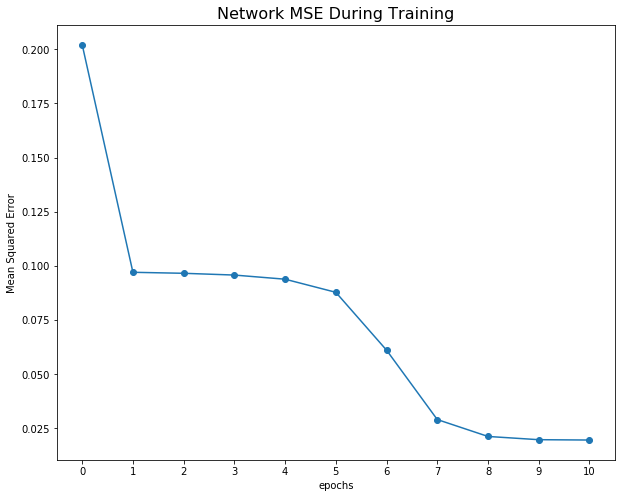

In [33]:
# Visualize the mean squared error over the training process 
plt.figure(figsize = (10, 8))
epochs = range(len(net.errors_))
plt.plot(epochs, net.errors_, marker = "o")
plt.xticks(epochs)
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.title("Network MSE During Training", fontsize = 16)
plt.show()

The MSE decreases over each epoch. Now we will make prediction on the testing set and show the confusion matrix and classificaiton report.

cf_matrix = [[1695   12]
 [  56  134]] 



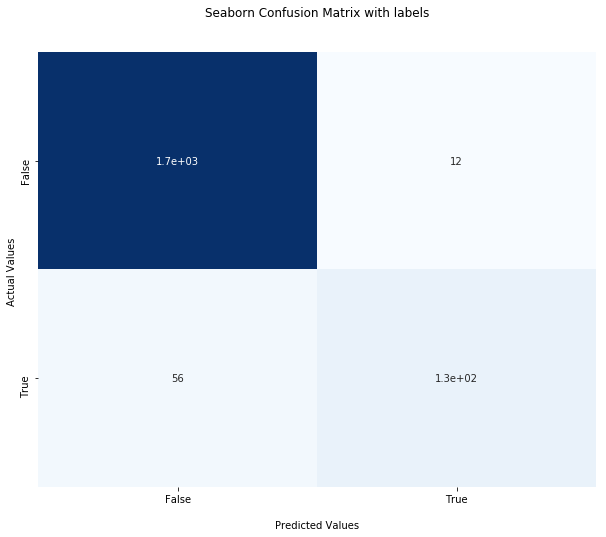

In [34]:
# Make predictions on testing data
y_pred = []
for xi in X_test:
    y_pred.append(net.predict(xi.reshape(-1,1)))

# Calculate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix 
print(f"cf_matrix = {cf_matrix} \n")

# View the confusion matrix using the seaborn package
plt.figure(figsize = (10, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False)

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [35]:
#Check performance of our model with classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98      1707
          1       0.92      0.71      0.80       190

avg / total       0.96      0.96      0.96      1897



The MLP model's accuracy is 96%, which performs well.

In [19]:
model.evaluate(X_test,  y_test, verbose=2)

9/9 - 0s - loss: 0.3544 - accuracy: 0.8587 - 77ms/epoch - 9ms/step


[0.3543647527694702, 0.8586956262588501]

The accuracy by using TensorFlow package is also about 86%.


## Conclusion

From the result above, we can see that the multilayer perceptron model performs well on the Shill Bidding dataset,for the multilayer perceptron model can deal with non-linearly separable data.